# Głębokie Sieci Neuronowe

### 1. Wymagane biblioteki

In [51]:
import os # Określanie lokacji plików
import numpy as np # Operacje na macierzach
import cv2 # Wczytywanie obrazów
import torch # PyTorch
import torch.nn as nn # Sieci neuronowe
import torch.nn.functional as F # Do specyfikacji funkcji
import random # Losowanie liczb
import time # Uzyskiwanie obecnego czasu
from albumentations import HorizontalFlip, VerticalFlip, Rotate # Morfologia obrazów
from torch.utils.data import Dataset # Zbiór danych do uczenia i trenowania
from torch.utils.data import DataLoader # Uzyskiwanie obrazu w danej epoce
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score # Wskaźniki jakości modelu
from operator import add # Łączenie zdjęć
import matplotlib.pyplot as plt # Wyświetlanie obrazów
from tqdm.notebook import tqdm # Pasek postępu
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Macierz pomyłek
import math # Operacje matematyczne

# Obrazy treningowe
train_img_path = os.path.abspath('train/images')
train_mask_path = os.path.abspath('train/ground_truth')

# Obrazy walidacyjne
validation_img_path = os.path.abspath('validate/images')
validation_mask_path = os.path.abspath('validate/ground_truth')

# Obrazy testowe
test_img_path = os.path.abspath('test/images')
test_mask_path = os.path.abspath('test/ground_truth')

# Lokacje zdjęć po augumentacji (zmianie rozmiaru, rotacji, itd)
train_augumented_path = os.path.abspath('train/augumented_images')
validation_augumented_path = os.path.abspath('validate/augumented_images')

# Tutaj zostaną zapisane wyniki detekcji modelem siecii
results_path = os.path.abspath('results')

# Tutaj zostanie zapisany model w trakcie uczenia
model_output = os.path.abspath('model')

### 2. Sieć UNET

![alt text](u-net-architecture.png "Sieć UNET")

In [2]:
class ConvolutionBlock(nn.Module):
    '''
    Fragment oznaczony jako "input image tile". Wykonuje się na nim konwolucję z funkcją aktywacjyjną ReLU oraz
    normalizacjcę za pomocą BatchNorm2d.
    '''
    
    def __init__(self, input_size, output_size):
        super().__init__()
        # Warstwy konwolucyjne 3x3
        self.conv_layer1 = nn.Conv2d(input_size, output_size, kernel_size=3, padding=1)
        self.conv_layer2 = nn.Conv2d(output_size, output_size, kernel_size=3, padding=1)
        
        # Warstwy normalizacyjne
        self.norm_layer1 = nn.BatchNorm2d(output_size)
        self.norm_layer2 = nn.BatchNorm2d(output_size)
        
        # Funkcja aktywacyjna ReLU
        self.relu = nn.ReLU()
    
    # Funkcja przekazująca dane przez warstwy
    def forward(self, inputs):
        x = self.conv_layer1(inputs)
        x = self.norm_layer1(x)
        x = self.relu(x)
        
        x = self.conv_layer2(x)
        x = self.norm_layer2(x)
        x = self.relu(x)
        
        return x

In [3]:
class PoolingBlock(nn.Module):
    '''
    Fragment przekazujący wynik konwolucji niżej (oznaczony na rysunku przez czerwoną strzałkę) w celu 
    dalszego zmniejszania obrazu.
    '''
    
    def __init__(self, input_size, output_size):
        super().__init__()
        self.conv_block = ConvolutionBlock(input_size, output_size)
        self.pool = nn.MaxPool2d((2, 2))
    
    # Funkcja przekazująca dane przez warstwy
    def forward(self, inputs):
        x = self.conv_block(inputs)
        p = self.pool(x)
        
        return x, p

In [4]:
class ExpansiveBlock(nn.Module):
    '''
    Fragment powiększający obraz do oryginalnej wielkości (oznaczony na rysunku przez zieloną strzałkę).
    '''
    def __init__(self, input_size, output_size):
        super().__init__()
        self.d = nn.ConvTranspose2d(input_size, output_size, kernel_size=2, stride=2, padding=0)
        self.conv_block = ConvolutionBlock(output_size + output_size, output_size)
    
    def forward(self, inputs, skip):
        x = self.d(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv_block(x)
        return x

In [5]:
class UNET(nn.Module):
    '''
    Cała sieć UNET do uczenia maszynowego. Skonstruowana zgodnie z obrazem.
    '''
    def __init__(self):
        super().__init__()
        self.pool_layer1 = PoolingBlock(3, 64)
        self.pool_layer2 = PoolingBlock(64, 128)
        self.pool_layer3 = PoolingBlock(128, 256)
        self.pool_layer4 = PoolingBlock(256, 512)
        
        self.conv_layer = ConvolutionBlock(512, 1024)
        
        self.exp_layer1 = ExpansiveBlock(1024, 512)
        self.exp_layer2 = ExpansiveBlock(512, 256)
        self.exp_layer3 = ExpansiveBlock(256, 128)
        self.exp_layer4 = ExpansiveBlock(128, 64)
        
        # Warstwa końcowa, z powiększonym obrazem
        self.output = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    
    # Praca sieci
    def forward(self, inputs):
        f1, p1 = self.pool_layer1(inputs)
        f2, p2 = self.pool_layer2(p1)
        f3, p3 = self.pool_layer3(p2)
        f4, p4 = self.pool_layer4(p3)
        
        b = self.conv_layer(p4)
        
        d1 = self.exp_layer1(b, f4)
        d2 = self.exp_layer2(d1, f3)
        d3 = self.exp_layer3(d2, f2)
        d4 = self.exp_layer4(d3, f1)
        
        output = self.output(d4)
        
        return output

### 3. Augumentacja obrazu

In [17]:
def augument_data(img_path, mask_path, output_path, img_size = (512, 512), augument = True):
    """
    Augumentacja obrazu.
    :param img_path: - ścieżka do zdjęć na których należy wykonać augumentację
    :param mask_path: - ścieżka do mask eksperckich zdjęć z zaznaczonymi żyłami
    :param img_size: - docelowy rozmiar obrazów po augumentacji
    :param augument: - czy dokonać morfologii obrazów, czy ograniczyć się tylko do zmiany rozmiaru
    """
    # Do wyświetlania postępu augumentacji
    num_images = len(os.listdir(img_path))
    for idx, image in enumerate(os.listdir(img_path)):
        print(f"Augumenting: {idx} / {num_images}...")
        
        # Wczytywanie obrazów do augumentacji
        img = cv2.imread(img_path + '/' + image, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path + '/' + image.split('.')[0] + '.tif', cv2.IMREAD_GRAYSCALE)
        
        if augument:
            # Odbicie poziome
            h_flip = HorizontalFlip(p=1.0)
            result1 = h_flip(image=img, mask=mask)
            
            # Odbicie pionowe
            v_flip = VerticalFlip(p=1.0)
            result2 = v_flip(image=img, mask=mask)
            
            # Rotacja
            rotate = Rotate(limit=45, p=1.0)
            result3 = rotate(image=img, mask=mask)

            # Zmiana rozmiaru tak, aby obraz pasował do rozmiaru warstw w siecii
            aug_img = cv2.resize(img, img_size)
            # Ekstrakcja obrazów do trenowania
            hflip_img = cv2.resize(result1["image"], img_size)
            vflip_img = cv2.resize(result2["image"], img_size)
            rotated_img = cv2.resize(result3["image"], img_size)
            # Zapisywanie obrazów
            cv2.imwrite(output_path + '/images/' + image, aug_img)
            cv2.imwrite(output_path + '/images/' + image.split('.')[0] + '_hflip.jpg', hflip_img)
            cv2.imwrite(output_path + '/images/' + image.split('.')[0] + '_vflip.jpg', vflip_img)
            cv2.imwrite(output_path + '/images/' + image.split('.')[0] + '_rotated.jpg', rotated_img)

            # Augumentacja maski w taki sam sposób jak obrazów
            aug_mask = cv2.resize(mask, img_size)
            hflip_mask = cv2.resize(result1["mask"], img_size)
            vflip_mask = cv2.resize(result2["mask"], img_size)
            rotated_mask = cv2.resize(result3["mask"], img_size)
            cv2.imwrite(output_path + '/ground_truth/' + image.split('.')[0] + '.tif', aug_mask)
            cv2.imwrite(output_path + '/ground_truth/' + image.split('.')[0] + '_hflip.tif', hflip_mask)
            cv2.imwrite(output_path + '/ground_truth/' + image.split('.')[0] + '_vflip.tif', vflip_mask)
            cv2.imwrite(output_path + '/ground_truth/' + image.split('.')[0] + '_rotated.tif', rotated_mask)
            

        else:
            augumented_image = cv2.resize(img, img_size)
            augumented_mask = cv2.resize(mask, img_size)
            cv2.imwrite(output_path + '/images/' + image, augumented_image)
            cv2.imwrite(output_path + '/ground_truth/' + image.split('.')[0] + '.tif', augumented_mask)

    return mask

### 4. Model DICE

In [9]:
# https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch?scriptVersionId=68471013&cellId=6
# Funkcja błędu typu Dice Loss
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

Model **BCE-Dice Loss** korzysta ze wzoru:

$J(w) = -\frac{1}{N} \sum_{n-1}^N [ y_n \text{log} \hat{y}_n + (1 - y_n) \text{log} (1 - \hat{y}_n) ]$

In [10]:
def srand(seed):
    '''
    Ustawianie losowych liczb.
    :seed: - zmienna na podstawie której ustala się podstawę liczb losowych
    '''
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    # Przekaż seed do PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
def get_epoch(start_time, end_time):
    '''
    Uzyskiwanie czasu, który upłynął między dwoma punktami w czasie.
    Do ustalania czasu trwania epoki.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 5. Trenowanie sieci

##### 1. Wczytywanie danych

In [18]:
augument_data(train_img_path, train_mask_path, train_augumented_path)
augument_data(validation_img_path, validation_mask_path, validation_augumented_path, augument=False)
srand(42)

train_images = [f"{train_augumented_path}/images/{image}" for image in os.listdir(train_augumented_path + '/images')]
train_masks = [f"{train_augumented_path}/ground_truth/{mask}" for mask in os.listdir(train_augumented_path + '/ground_truth')]
validation_images = [f"{validation_augumented_path}/images/{image}" for image in os.listdir(validation_augumented_path + '/images')]
validation_masks = [f"{validation_augumented_path}/ground_truth/{mask}" for mask in os.listdir(validation_augumented_path + '/ground_truth')]

print(f"Dataset contains:\n{len(train_images)} training images\n{len(validation_images)} validation images")

Augumenting: 0 / 30...
Augumenting: 1 / 30...
Augumenting: 2 / 30...
Augumenting: 3 / 30...
Augumenting: 4 / 30...
Augumenting: 5 / 30...
Augumenting: 6 / 30...
Augumenting: 7 / 30...
Augumenting: 8 / 30...
Augumenting: 9 / 30...
Augumenting: 10 / 30...
Augumenting: 11 / 30...
Augumenting: 12 / 30...
Augumenting: 13 / 30...
Augumenting: 14 / 30...
Augumenting: 15 / 30...
Augumenting: 16 / 30...
Augumenting: 17 / 30...
Augumenting: 18 / 30...
Augumenting: 19 / 30...
Augumenting: 20 / 30...
Augumenting: 21 / 30...
Augumenting: 22 / 30...
Augumenting: 23 / 30...
Augumenting: 24 / 30...
Augumenting: 25 / 30...
Augumenting: 26 / 30...
Augumenting: 27 / 30...
Augumenting: 28 / 30...
Augumenting: 29 / 30...
Augumenting: 0 / 10...
Augumenting: 1 / 10...
Augumenting: 2 / 10...
Augumenting: 3 / 10...
Augumenting: 4 / 10...
Augumenting: 5 / 10...
Augumenting: 6 / 10...
Augumenting: 7 / 10...
Augumenting: 8 / 10...
Augumenting: 9 / 10...
Dataset contains:
120 training images
10 validation images


##### 2. Dataset

In [20]:
class ImageDataset(Dataset):
    '''
    Obiekt upraszczający wczytywanie danych do trenowania sieci. Wymagany przez Keras.
    '''

    def __init__(self, train_img_paths, train_mask_paths):
        super().__init__()
        self.train_img_paths = train_img_paths
        self.train_mask_paths = train_mask_paths
        self.num_samples = len(self.train_img_paths)
    
    def __getitem__(self, index):
        image = cv2.imread(self.train_img_paths[index], cv2.IMREAD_COLOR)
        # Normalizacja obrazu
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))
        # Konwersja z wartości int na float (wymaga tego torch)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        
        mask = cv2.imread(self.train_mask_paths[index], cv2.IMREAD_GRAYSCALE)
        # Normalizacja obrazu
        mask = mask / 255.0
        # Rozszerzanie obrazu o dodatkowy wymiar (kanału)
        mask = np.expand_dims(mask, axis=0)
        # Konwersja z wartości int na float (wymaga tego torch)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        
        return image, mask
    
    def __len__(self):
        return self.num_samples

##### 3. Tworzenie modelu

In [21]:
# Docelowy rozmiar obrazu podawany do sieci
img_size = (512, 512)
# Ile obrazów na raz przetwarzać w sieci
batch_size = 2
# Ile epok ma trwać uczenie
num_epochs = 50
# Prędkość uczenia sieci
learning_rate = 1e-4
# Gdzie zapisywać model przy poprawie jakości modelu
checkpoint_path = model_output + '/model.pth'

# Zbiory danych
train_dataset = ImageDataset(train_images, train_masks)
validation_dataset = ImageDataset(validation_images, validation_masks)

# Podział zbioru danych na podzbiory o rozmiarze batch_size
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

# Tworzenie modelu
device = torch.device('cuda')
model = UNET()
model = model.to(device)

# Optimalizator Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Zmniejszaj Learning Rate przy braku postępu w celu optymalizacji uczenia
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
# Funkcja błędu
loss_function = DiceBCELoss()

##### 4. Uczenie modelu

In [22]:
def train(model, loader, optimizer, loss_function, device):
    '''
    Algorytm uczenia.
    :param model: - model sieci
    :param loader: - obiekt wczytujący dane uczące
    :param optimizer: - optymalizator
    :param loss_function: - funkcja obliczająca błąd, na podstawie którego wyznaczane są wagi
    :param device: - urządzenie uczące (gpu lub cpu)
    '''
    epoch_loss = 0.0
    model.train()
    for img_tensor, mask_tensor in loader:
        img_tensor = img_tensor.to(device, dtype=torch.float32)
        mask_tensor = mask_tensor.to(device, dtype=torch.float32)
        
        optimizer.zero_grad()
        prediction = model(img_tensor)
        loss = loss_function(prediction, mask_tensor)
        # Wsteczna propagacja
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Obliczanie średniego błędu
    epoch_loss = epoch_loss / len(loader)
    return epoch_loss

In [23]:
def evaluate(model, loader, loss_function, device):
    '''
    Ewaluacja jakości modelu na podstawie danych walidacyjnych.
    :param model: - model do ewaluacji
    :param loader: - obiekt wczytujący dane walidacyjne
    :param loss_function: - funkcja błędu pomiaru
    :param device: - urządzenie wykonujące walidację (gpu lub cpu)
    '''
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for img_tensor, mask_tensor in loader:
            img_tensor = img_tensor.to(device, dtype=torch.float32)
            mask_tensor = mask_tensor.to(device, dtype=torch.float32)

            prediction = model(img_tensor)
            loss = loss_function(prediction, mask_tensor)

            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

In [24]:
min_loss = float("inf")
# Zwalnianie danych w urządzeniu uczącym, zapobiega błędowi CUDA Out of Memory
torch.cuda.empty_cache()

for epoch in range(num_epochs):
    start_time = time.time()

    training_loss = train(model, train_loader, optimizer, loss_function, device)
    validation_loss = evaluate(model, validation_loader, loss_function, device)
    
    # Zapisuj model jeżeli jego jakość się poprawi
    if validation_loss < min_loss:
        print(f"Validation loss reduced from {min_loss} to {validation_loss}, saving model...")
        min_loss = validation_loss
        torch.save(model.state_dict(), checkpoint_path)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = get_epoch(start_time, end_time)
    
    # Wypisz dane diagnostyczne
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {training_loss:.3f}')
    print(f'\t Val. Loss: {validation_loss:.3f}\n')

Validation loss reduced from inf to 1.086718702316284, saving model...
Epoch: 01 | Epoch Time: 2m 39s
	Train Loss: 1.156
	 Val. Loss: 1.087



KeyboardInterrupt: 

Ponieważ proces uczenia na komputerze lokalnym jest wolny, model został wyuczony na notatniku **Google Colab** i zapisany w folderze `model`.

### 6. Testowanie sieci

##### 1. Wczytywanie modelu

In [31]:
srand(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNET()
model = model.to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

UNET(
  (pool_layer1): PoolingBlock(
    (conv_block): ConvolutionBlock(
      (conv_layer1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_layer1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm_layer2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (pool_layer2): PoolingBlock(
    (conv_block): ConvolutionBlock(
      (conv_layer1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_layer2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_layer1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm_layer2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

##### 2. Predykcja

In [77]:
test_images = [f"{test_img_path}/{img}" for img in os.listdir(test_img_path)]
test_masks = [f"{test_mask_path}/{mask}" for mask in os.listdir(test_mask_path)]

In [87]:
def get_prediction(image_path, model, probability = 0.3):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, img_size)
    image = np.transpose(image, (2, 0, 1))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    image = image.astype(np.float32)
    image = torch.from_numpy(image)
    image = image.to(device)
    
    with torch.no_grad():
        prediction = model(image)
        prediction = torch.sigmoid(prediction)
        prediction = prediction[0].cpu().numpy()
        prediction = np.squeeze(prediction, axis=0)
        prediction = prediction > probability
        prediction = np.array(prediction, dtype=np.uint8)
        
    return prediction

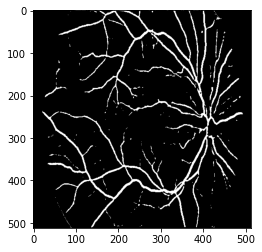

In [104]:
prediction = get_prediction(test_images[0], model, 0.43)
plt.imshow(prediction, cmap="gray")

### 7. Analiza statystyczna

**Funkcje do analizy są przekopiowane z notatnika z morfologią (na 3.0).**

In [116]:
def get_confusion_matrix(data):
    predictions, truth = data
    true_positives = 0
    false_positives = 0
    true_negatives = 0
    false_negatives = 0
    print("Creating confusion matrix...")
    for idx, val in enumerate(tqdm(predictions)):
        if val == truth[idx]:
            if val == 1:
                true_positives += 1
            else:
                true_negatives += 1
        else:
            if val == 1:
                false_positives += 1
            else:
                false_negatives += 1

    confusion_matrix = np.matrix([
        [true_negatives, false_positives],
        [false_negatives, true_positives]
    ])
    return confusion_matrix

def get_analsyis_metrics(TP, TN, FP, FN):
    # Accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Sensitivity = TP / (TP + FN)
    sensitivity = TP / (TP + FN)
    # Specificity = TN / (TN + FP)
    specificity = TN / (TN + FP)
    # Balanced Accuracy = (Sensitivity + Specificity) / 2
    balanced_accuracy = (sensitivity + specificity) / 2
    # Geometric Accuracy = Sqrt(Sensitivity * Specificity)
    geometric_accuracy = math.sqrt(sensitivity * specificity)
    
    return [accuracy, sensitivity, specificity, balanced_accuracy, geometric_accuracy]

def print_analysis(img_path, mask_path, model, certainty):
    prediction = get_prediction(img_path, model, certainty)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    data = [np.concatenate(prediction), np.concatenate(mask)]
    mat = get_confusion_matrix(data)
    disp = ConfusionMatrixDisplay(confusion_matrix=mat)
    disp.plot()
    plt.show()
    metrics = get_analsyis_metrics(mat[1, 1], mat[0, 0], mat[0, 1], mat[1, 0])
    print(f"Trafność: {int(metrics[0] * 100)}%")
    print(f"Czułość: {int(metrics[1] * 100)}%")
    print(f"Swoistość: {int(metrics[2] * 100)}%")
    print(f"Zrównoważona trafność (średnia arytmetyczna): {int(metrics[3] * 100)}%")
    print(f"Zrównoważona trafność (średnia geometryczna): {int(metrics[4] * 100)}%")

Creating confusion matrix...


  0%|          | 0/262144 [00:00<?, ?it/s]

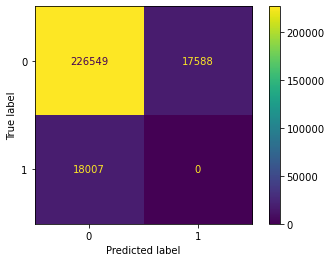

Trafność: 86%
Czułość: 0%
Swoistość: 92%
Zrównoważona trafność (średnia arytmetyczna): 46%
Zrównoważona trafność (średnia geometryczna): 0%


In [117]:
print_analysis(test_images[0], test_masks[0], model, 0.5)

Creating confusion matrix...


  0%|          | 0/262144 [00:00<?, ?it/s]

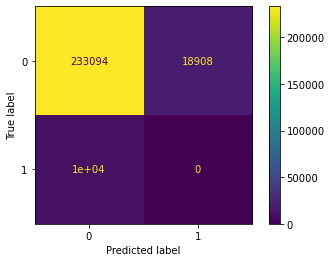

Trafność: 88%
Czułość: 0%
Swoistość: 92%
Zrównoważona trafność (średnia arytmetyczna): 46%
Zrównoważona trafność (średnia geometryczna): 0%


In [118]:
print_analysis(test_images[1], test_masks[1], model, 0.38)

Creating confusion matrix...


  0%|          | 0/262144 [00:00<?, ?it/s]

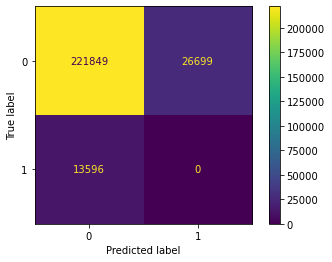

Trafność: 84%
Czułość: 0%
Swoistość: 89%
Zrównoważona trafność (średnia arytmetyczna): 44%
Zrównoważona trafność (średnia geometryczna): 0%


In [122]:
print_analysis(test_images[2], test_masks[2], model, 0.43)

Creating confusion matrix...


  0%|          | 0/262144 [00:00<?, ?it/s]

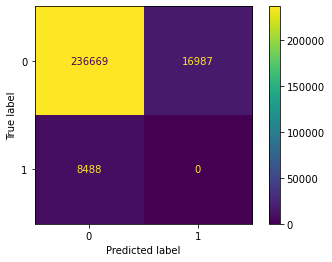

Trafność: 90%
Czułość: 0%
Swoistość: 93%
Zrównoważona trafność (średnia arytmetyczna): 46%
Zrównoważona trafność (średnia geometryczna): 0%


In [131]:
print_analysis(test_images[3], test_masks[3], model, 0.36)

Creating confusion matrix...


  0%|          | 0/262144 [00:00<?, ?it/s]

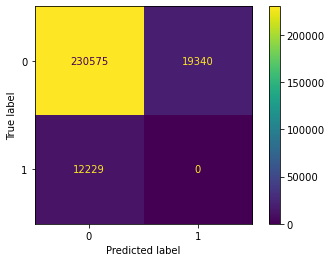

Trafność: 87%
Czułość: 0%
Swoistość: 92%
Zrównoważona trafność (średnia arytmetyczna): 46%
Zrównoważona trafność (średnia geometryczna): 0%


In [134]:
print_analysis(test_images[4], test_masks[4], model, 0.4)